#### 1. Loading dataset

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import datetime as dt

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:
# read the file

df_clean = pd.read_csv('./Data/df_clean.csv')
df_clean.head(1)

,video_id,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name,country,clean_text
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,People & Blogs,usa,asked girlfriend


In [39]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36355 entries, 0 to 36354
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           36355 non-null  object
 1   title              36355 non-null  object
 2   publishedAt        36355 non-null  object
 3   channelTitle       36355 non-null  object
 4   categoryId         36355 non-null  int64 
 5   trending_date      36355 non-null  object
 6   tags               36355 non-null  object
 7   view_count         36355 non-null  int64 
 8   likes              36355 non-null  int64 
 9   dislikes           36355 non-null  int64 
 10  comment_count      36355 non-null  int64 
 11  comments_disabled  36355 non-null  bool  
 12  ratings_disabled   36355 non-null  bool  
 13  description        36355 non-null  object
 14  category_name      36355 non-null  object
 15  country            36355 non-null  object
 16  clean_text         36328 non-null  objec

In [40]:
df_cat = pd.DataFrame (df_clean.loc[(df_clean['category_name'] == 'Gaming') | (df_clean['category_name'] == 'Entertainment') | (df_clean['category_name'] == 'Music') \
       | (df_clean['category_name'] == 'Sports')])

In [41]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24425 entries, 1 to 36354
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           24425 non-null  object
 1   title              24425 non-null  object
 2   publishedAt        24425 non-null  object
 3   channelTitle       24425 non-null  object
 4   categoryId         24425 non-null  int64 
 5   trending_date      24425 non-null  object
 6   tags               24425 non-null  object
 7   view_count         24425 non-null  int64 
 8   likes              24425 non-null  int64 
 9   dislikes           24425 non-null  int64 
 10  comment_count      24425 non-null  int64 
 11  comments_disabled  24425 non-null  bool  
 12  ratings_disabled   24425 non-null  bool  
 13  description        24425 non-null  object
 14  category_name      24425 non-null  object
 15  country            24425 non-null  object
 16  clean_text         24410 non-null  objec

In [42]:
df = pd.DataFrame (df_cat,columns = ['category_name','clean_text'])

In [43]:
df.head()

,category_name,clean_text
1,Gaming,apex legends stories outlands endorsement
2,Entertainment,left youtube month happened
3,Music,xxl freshman class revealed official announcement
5,Entertainment,havent honest injury heres truth
8,Entertainment,surprising dad dream truck louies life


In [44]:
# Create a new column 'label_id' with encoded categories 
df['category_name_id'] = df['category_name'].factorize()[0]
new_df = df[['category_name', 'category_name_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(new_df.values)
id_to_category = dict(new_df[['category_name_id', 'category_name']].values)
# New dataframe
df.head()

,category_name,clean_text,category_name_id
1,Gaming,apex legends stories outlands endorsement,0
2,Entertainment,left youtube month happened,1
3,Music,xxl freshman class revealed official announcement,2
5,Entertainment,havent honest injury heres truth,1
8,Entertainment,surprising dad dream truck louies life,1


#### 2. Feature engineering - tfidf

In [45]:
# clean text
import re
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(" \d+", " ", text) # remove digits
    text = re.sub(" #\d+", " ", text) # remove digits starting with # symbol
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
df['clean_text'] = df['clean_text'].apply(clean_text)


In [46]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=100,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each news data into a vector
features = tfidf.fit_transform(df.clean_text).toarray()
category_name = df.category_name_id
print("Each of the %d news data is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 24425 news data is represented by 187 features (TF-IDF score of unigrams and bigrams)


In [47]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, category_name == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> ", (Category), ":")
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==>  Entertainment :
  * Most Correlated Unigrams are: video, shorts, highlights
  * Most Correlated Bigrams are: official music, official trailer, official video

==>  Gaming :
  * Most Correlated Unigrams are: mod, fortnite, minecraft
  * Most Correlated Bigrams are: friday night, music video, official video

==>  Music :
  * Most Correlated Unigrams are: music, official, video
  * Most Correlated Bigrams are: official music, music video, official video

==>  Sports :
  * Most Correlated Unigrams are: league, vs, highlights
  * Most Correlated Bigrams are: premier league, league highlights, game highlights


In [48]:
X = df['clean_text']
y = df['category_name'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
print("shape of x_train set :", X_train.shape)
print("shape of y_train set :",y_train.shape)
print("shape of x_test set :",X_test.shape)
print("shape of y_test set :",y_test.shape)

shape of x_train set : (18318,)
shape of y_train set : (18318,)
shape of x_test set : (6107,)
shape of y_test set : (6107,)


In [60]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    MultinomialNB(),
    BernoulliNB(),
    DecisionTreeClassifier(random_state=0),
    LogisticRegression(random_state=0),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=3)
                         ]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, category_name, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [61]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
BernoulliNB,0.681310,0.030024
DecisionTreeClassifier,0.695599,0.022066
GaussianNB,0.506530,0.019470
KNeighborsClassifier,0.635169,0.049382
LogisticRegression,0.706981,0.021744
MultinomialNB,0.694043,0.023695
RandomForestClassifier,0.594719,0.017318


In [51]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               category_name, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATIION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['category_name'].unique()))

			CLASSIFICATIION REPORT

               precision    recall  f1-score   support

       Gaming       0.78      0.55      0.64      1258
Entertainment       0.57      0.83      0.68      1921
        Music       0.85      0.72      0.78      1202
       Sports       0.89      0.73      0.80      1726

     accuracy                           0.72      6107
    macro avg       0.77      0.71      0.73      6107
 weighted avg       0.76      0.72      0.73      6107



In [52]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7219584083838219


Text(0.5, 1.0, 'CONFUSION MATRIX - Logistic Regression\n')

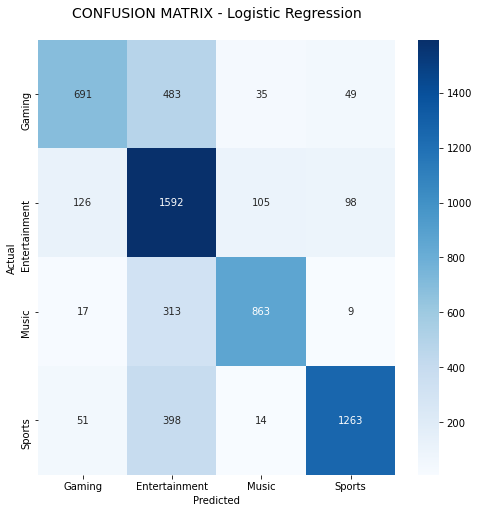

In [53]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.category_name.values, 
            yticklabels=new_df.category_name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size=14)

In [54]:
for predicted in new_df.category_name_id:
    for actual in new_df.category_name_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category_name', 
                                                                'clean_text']])
            print('')

actual class 'Entertainment' predicted as 'Gaming' : 126 examples.


,category_name,clean_text
18528,Entertainment,wedding story
4017,Entertainment,trying tik tok trends new baby pup
20017,Entertainment,opened fifa packs got messi ronaldo cost ___
34337,Entertainment,john whaite johannes radebe tango blue monday ...
15570,Entertainment,lexy wants favor jake sneak peek chucky tv ser...
...,...,...
26367,Entertainment,jai survcu jours en hardcore sur minecraft voi...
14721,Entertainment,behind set squid game
17321,Entertainment,wont believe said free haircut public
12780,Entertainment,minecraft im fish



actual class 'Sports' predicted as 'Gaming' : 51 examples.


,category_name,clean_text
28974,Sports,schoolboy beat whole gym arm wrestling
5598,Sports,james harden officially wants houston hes even...
3843,Sports,skip shannon james harden denying historic con...
17249,Sports,heated gervonta tank davis shoves pitbull cruz...
35510,Sports,atalanta roma abraham nets two huge roma win b...
12266,Sports,day nba free agency absolutely insane
14128,Sports,full video canelo swerves caleb plant slap lan...
20994,Sports,greatest game horse
11860,Sports,giannis prove james harden wrong winning title...
184,Sports,nba k21 everything game current gen gameplay



actual class 'Gaming' predicted as 'Entertainment' : 483 examples.


,category_name,clean_text
17683,Gaming,escaping viewers impossible prison
17949,Gaming,fnaf security breach speedruns incredibly broken
13334,Gaming,youtube gave strike wont tell
16201,Gaming,played elden ring hours thoughts
26301,Gaming,je debloque le pouvoir de spider man avec cett...
...,...,...
31807,Gaming,try aww
35451,Gaming,collected miscellany arataki itto supreme supe...
3088,Gaming,tsm bjergsen announcement
9936,Gaming,everyone found channel



actual class 'Music' predicted as 'Entertainment' : 313 examples.


,category_name,clean_text
35585,Music,ksi show
31981,Music,dooms night official trailer txt
22741,Music,sch loup noir colors show
19664,Music,nicki minaj ft lil baby problem official music...
869,Music,ay dios mo
...,...,...
19097,Music,yelawolf shooter jennings make believer music ...
27706,Music,fka twigs sad day
30831,Music,james arthur drivers license olivia rodrigo cover
9345,Music,omg j cole freestyles til infinity mike jones ...



actual class 'Sports' predicted as 'Entertainment' : 398 examples.


,category_name,clean_text
25870,Sports,fathers favorite fighter khabib nurmagomedov g...
24424,Sports,secret great ball striking driver irons
205,Sports,unique start training camp hard knocks los ang...
3906,Sports,michael jordan make right choice drafting lame...
6242,Sports,siempre gignac tigres ulsan hyundai mundial
...,...,...
25640,Sports,big ol austin quiz max verstappen sergio perez...
24637,Sports,perfect really happened derrick lewis v ciryl ...
36270,Sports,mclarens bold decisions f1 car
34334,Sports,dont fancy aj rematch carl froch honest though...



actual class 'Gaming' predicted as 'Music' : 35 examples.


,category_name,clean_text
6016,Gaming,kaldheim official cinematic magic gathering
7208,Gaming,9 million home stretch
33433,Gaming,reacting last w2s video
25078,Gaming,video satisfy brain
31520,Gaming,gotta deal bad little cousin dankscole #shorts
30745,Gaming,stampys lovely world rtx ray tracing world tour
19970,Gaming,kamigawa neon dynasty official cinematic magic...
22696,Gaming,among us mais avec baby yoda et dark vador fea...
34113,Gaming,children video games creepy kids
1737,Gaming,toosii nightmares ft lil durk official audio



actual class 'Entertainment' predicted as 'Music' : 105 examples.


,category_name,clean_text
502,Entertainment,bts dynamite official teaser reaction brizzy t...
5508,Entertainment,rylo rodriguez home run official music video
33221,Entertainment,chip clash official audio reaction leetothevi
17095,Entertainment,shawn mendes itll okay lyric video
21200,Entertainment,tibo inshape rconciliation feat juju fitcats c...
...,...,...
32377,Entertainment,elena tsagrinou el diablo first rehearsal cypr...
8041,Entertainment,rejected lil nas x nike satan shoes free truth
24736,Entertainment,hart heart jimmy kimmel f# ing matt damon vide...
15579,Entertainment,made funniest song georgenotfound wilbursoot



actual class 'Gaming' predicted as 'Sports' : 49 examples.


,category_name,clean_text
18648,Gaming,used time travel beat fnaf sb without running
885,Gaming,monster hunter world iceborne developer diary ...
19070,Gaming,gigantamax pokmon battle royale explained gnog...
32449,Gaming,hosted biggest rocket league kahoot gave winner
27664,Gaming,win king clash trivia show clash clans
19339,Gaming,dbfz shenanigoons vs ssj4 gogeta raid boss rev...
14287,Gaming,vinesauce vinny reacts cast mario movie
34683,Gaming,gta trilogy original vs definitive edition ear...
11207,Gaming,challenged russian paul strongest chess hustle...
19680,Gaming,turning logan paul ksis prime cocktails



actual class 'Entertainment' predicted as 'Sports' : 98 examples.


,category_name,clean_text
4668,Entertainment,things make sense
28679,Entertainment,lampard mourinho solksjaer klopp round weekend
9951,Entertainment,randy orton uses matt riddles bro derek finish...
30801,Entertainment,highlights hollys birthday show minutes morning
5957,Entertainment,levi vs beast titan round attack titan season ...
...,...,...
30490,Entertainment,show talent win free stuff
14448,Entertainment,english daisy paint match hard
33370,Entertainment,love islands brad reacts lucinda aaron reveals...
27760,Entertainment,manchester united sign donny van de beek rio r...


#### Implementing Gridsearch

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [86]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , LogisticRegression())])
# pipe = Pipeline([('classifier', LogisticRegression())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-10, 10, 100),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [LogisticRegression()],}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 2010 out of 2010 | elapsed:  1.3min finished


In [87]:
best_clf.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.7924828983539186, penalty='l1', solver='liblinear')

In [88]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.7183559849353202


In [89]:
classes = best_clf.predict(X_test)
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.54      0.80      0.64       847
           1       0.84      0.56      0.67      2859
           2       0.71      0.86      0.78       995
           3       0.72      0.89      0.80      1406

    accuracy                           0.72      6107
   macro avg       0.70      0.78      0.72      6107
weighted avg       0.75      0.72      0.71      6107

